# Create PAO1 and PA14 compendia

This notebook is using the thresholds from the [previous notebook](0_decide_thresholds.ipynb) to bin samples into PAO1 or PA14 compendia.

A sample will be PAO1 if:
1. PAO1 mapping rate >= 30%
2. PAO1-PA14 mapping rate > 0%

Note: if the difference in mapping rate is 0 then the same maps equally well to a PAO1 and PA14 reference. Here we looking for samples that preferentially map to PAO1.

A sample will be PA14 if:
1. PA14 mapping rate >= 30%
2. PA14-PAO1 mapping rate > 0%

In [39]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
from core_acc_modules import paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Params
mapping_threshold = 30
diff_mapping_threshold = 2
diff_mapping_threshold_min = 0
diff_mapping_threshold_max = 2

## Load data

In [3]:
# Log files
pao1_logs_filename = paths.PAO1_LOGS
pa14_logs_filename = paths.PA14_LOGS

# Expression data files
pao1_expression_filename = paths.PAO1_GE
pa14_expression_filename = paths.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [4]:
# Load log files
pao1_logs = pd.read_csv(pao1_logs_filename, index_col=0, header=0)
pa14_logs = pd.read_csv(pa14_logs_filename, index_col=0, header=0)

# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T

pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

# Drop row with gene ensembl ids
pao1_expression.drop(["X"], inplace=True)
pa14_expression.drop(["X"], inplace=True)

# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

In [5]:
sample_to_strain_table_full.head()

,Unnamed: 0,Run,Sample.Name,SRA_study,BioProject,GEO_Accession..exp.,source_name,Strain,PAO1,PA14,PAK,ClinicalIsolate
Experiment,,,,,,,,,,,,
SRX5057740,1,SRR8239475,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057739,2,SRR8239476,CLJ1,SRP170343,PRJNA383797,NaN,NaN,CLJ1,False,False,False,False
SRX5057910,3,SRR8239645,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX5057909,4,SRR8239646,CLJ3,SRP170410,PRJNA383798,NaN,NaN,CLJ3,False,False,False,False
SRX3573046,5,SRR6483189,PAO1 samples from Colistin/Doripenem treatment,SRP130183,PRJNA414673,NaN,NaN,PAO1,True,False,False,False


In [6]:
pao1_logs.head()

,lib_types,reads_processed,reads_mapped,mapping_rate,run,job
exp_num,,,,,,
SRP090296/SRX2185323/SRX2185323,[u'SF'],47468450,5240148,11.039223,78041,2724
ERP105395/ERX2259197/ERX2259197,[u'U'],34109390,16420150,48.139676,78036,984
SRP017679/SRX2366135/SRX2366135,[u'U'],9912084,4322668,43.610082,78042,1232
SRP038697/SRX474161/SRX474161,[u'SF'],710589,93493,13.157113,78041,2560
SRP062215/SRX1140456/SRX1140456,[u'SF'],6598795,470748,7.133848,78042,1439


In [7]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571.ERX541571.salmon,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572.ERX541572.salmon,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573.ERX541573.salmon,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574.ERX541574.salmon,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575.ERX541575.salmon,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


## Format data

Format index to only include experiment id. This will be used to map to expression data and labels

In [8]:
# Format log indices so that values can be mapped to expression data
pao1_index_processed = pao1_logs.index.str.split("/").str[-1]
pa14_index_processed = pa14_logs.index.str.split("/").str[-1]

print(f"No. of samples processed using PAO1 reference: {pao1_logs.shape[0]}")
print(f"No. of samples processed using PA14 reference: {pa14_logs.shape[0]}")
pao1_logs.index = pao1_index_processed
pa14_logs.index = pa14_index_processed

No. of samples processed using PAO1 reference: 2852
No. of samples processed using PA14 reference: 2852


In [9]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

print(
    f"No. of samples processed using PAO1 reference after filtering: {pao1_expression.shape}"
)
print(
    f"No. of samples processed using PA14 reference after filtering: {pa14_expression.shape}"
)
pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

No. of samples processed using PAO1 reference after filtering: (2643, 5563)
No. of samples processed using PA14 reference after filtering: (2619, 5891)


In [10]:
pao1_logs.head()

,lib_types,reads_processed,reads_mapped,mapping_rate,run,job
exp_num,,,,,,
SRX2185323,[u'SF'],47468450,5240148,11.039223,78041,2724
ERX2259197,[u'U'],34109390,16420150,48.139676,78036,984
SRX2366135,[u'U'],9912084,4322668,43.610082,78042,1232
SRX474161,[u'SF'],710589,93493,13.157113,78041,2560
SRX1140456,[u'SF'],6598795,470748,7.133848,78042,1439


In [11]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,186.695,41.0399,52.6869,42.5596,11.8271,49.6818,15.1125,18.9761,39.7944,7.90016,...,0,5.16485,8.34185,2.24955,16.7872,35.8977,35.3801,117.821,133.373,0
ERX541572,200.587,36.65,65.5425,40.1072,15.0975,38.9103,9.27882,13.3374,35.814,4.29789,...,0,4.02765,8.1123,2.13563,13.5472,21.0032,26.6635,109.515,99.2929,0
ERX541573,111.42,27.4148,56.0137,25.2659,18.6952,22.6177,7.28033,8.25073,22.8004,2.72297,...,0,3.55578,8.70387,2.63218,20.6529,13.5422,33.1718,47.4317,34.1095,0
ERX541574,143.32,34.4773,83.4517,39.3797,23.2258,30.0783,12.3878,11.1666,26.4343,7.74561,...,0,7.79597,9.47563,4.12049,16.6373,15.0784,24.8545,97.8814,36.5146,5.00512
ERX541575,118.398,34.014,73.7324,32.2136,21.2469,23.1491,6.74443,13.0066,33.6489,4.74327,...,0,5.56938,9.57055,2.4523,32.6727,8.08117,47.4864,66.6335,26.2999,0


In [12]:
# Save pre-binned expression data
pao1_expression.to_csv(paths.PAO1_PREBIN_COMPENDIUM, sep="\t")
pa14_expression.to_csv(paths.PA14_PREBIN_COMPENDIUM, sep="\t")

In [13]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [14]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Bin samples as PAO1 or PA14

* Bin samples based on threshold from previous notebook
* Check if there are any samples that have a high mapping to both PAO1 and PA14 (i.e. ambiguous mapping)

In [15]:
# Add column calculating the difference in mapping rates
pao1_logs["diff_mapping_rate"] = pao1_logs["mapping_rate"] - pa14_logs["mapping_rate"]
pa14_logs["diff_mapping_rate"] = pa14_logs["mapping_rate"] - pao1_logs["mapping_rate"]

In [16]:
high_pao1_mapping_ids = list(
    pao1_logs.query(
        "mapping_rate>=@mapping_threshold&diff_mapping_rate>@diff_mapping_threshold"
    ).index
)
high_pa14_mapping_ids = list(
    pa14_logs.query(
        "mapping_rate>=@mapping_threshold&diff_mapping_rate>@diff_mapping_threshold"
    ).index
)

"""high_pao1_mapping_ids = list(
    pao1_logs.query("mapping_rate>=@mapping_threshold&diff_mapping_rate>@diff_mapping_threshold_min&diff_mapping_rate<@diff_mapping_threshold_max").index
)
high_pa14_mapping_ids = list(
    pa14_logs.query("mapping_rate>=@mapping_threshold&diff_mapping_rate>@diff_mapping_threshold_min&diff_mapping_rate<@diff_mapping_threshold_max").index
)"""

print(len(high_pao1_mapping_ids))
print(len(high_pa14_mapping_ids))

454
298


In [17]:
# Check if any ids have high mapping rate for both PAO1 and PA14
high_pao1_pa14_mapping_ids = list(
    set(high_pao1_mapping_ids).intersection(high_pa14_mapping_ids)
)

print(len(high_pao1_pa14_mapping_ids))

0


**Some observations:**
* Looks like there are not any samples that map to both PAO1 and PA14 using our criteria
* The number of PA14 samples is much lower compared to PAO1. Does this mean that the mapping rates of PA14 samples mapped to PA14 reference lower?

## Create compendia

Create PAO1 and PA14 compendia

In [18]:
# Get expression data
# Note: reindexing needed here instead of .loc since samples from expression data
# were filtered out for low counts, but these samples still exist in log files
pao1_expression_binned = pao1_expression.reindex(high_pao1_mapping_ids)
pa14_expression_binned = pa14_expression.reindex(high_pa14_mapping_ids)

# Missing samples are dropped
pao1_expression_binned = pao1_expression_binned.dropna()
pa14_expression_binned = pa14_expression_binned.dropna()

# Drop ambiguously mapped samples
pao1_expression_binned = pao1_expression_binned.drop(high_pao1_pa14_mapping_ids)
pa14_expression_binned = pa14_expression_binned.drop(high_pao1_pa14_mapping_ids)

In [19]:
print(pao1_expression_binned.shape)
print(pa14_expression_binned.shape)

(451, 5563)
(287, 5891)


In [20]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression_binned.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression_binned.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(451, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX2259197,216.996,128.524,163.214,161.491,63.3263,96.489,32.8,37.557,16.2432,12.9643,...,27.8633,117.778,20.258,54.9933,151.674,219.596,142.471,82.5884,5.61906,PAO1
SRX3449591,844.388,323.628,310.649,186.684,73.8539,34.3788,18.2467,86.3048,345.824,11.5453,...,29.5651,71.4001,40.6517,24.7365,360.053,40.1435,389.952,85.3784,0,NA
SRX7058512,165.923,212.205,203.552,119.648,19.4932,14.2625,23.7125,18.5544,51.5497,10.1364,...,41.8648,157.088,17.6516,27.6436,109.678,1119.41,67.5321,37.5304,0,PAO1
SRX1737670,199.373,244.951,88.7191,150.457,39.1562,66.976,74.0398,26.844,11.8257,15.5774,...,28.2424,38.7751,36.1839,18.1109,147.197,41.7682,77.1208,47.393,0,PAO1
SRX1156138,320.578,389.495,158.324,158.169,88.7245,100.434,46.2074,51.9284,65.4698,28.1263,...,16.591,41.6911,27.8349,24.0554,106.428,29.0536,90.9548,89.2357,0,PAO1


In [21]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(287, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
SRX5572898,2.3915,9.72503,7.04368,0,63.4716,0,0,1.57778,3.23935,0,...,13.9411,112.077,3.10787,0,50.4318,82.9069,13.6853,7.68149,272.192,PA14
SRX6437618,109.835,83.0553,24.1295,295.538,148.009,109.167,150.7,49.8749,34.5821,53.9383,...,219.799,94.5159,0,797.955,493.619,230.1,54.4537,136.566,1655.98,NA
SRX470367,5.59222,4.45054,2.98041,12.391,12.9644,1.18911,4.49075,2.66328,4.25293,0,...,18.9742,122.682,29.0732,0,537.53,191.751,22.2177,14.597,187.739,PA14
SRX2962082,22.292,26.6495,38.8109,39.1839,10.4767,5.47887,3.2148,7.14931,1.90278,2.18106,...,99.989,91.0151,3.15526,0,0,78.7489,39.029,17.5453,0,PAO1
SRX8030416,11.1343,17.4281,16.2865,290.718,145.936,22.8474,10.0056,18.2748,12.5406,3.01893,...,14.445,47.4822,57.4443,2.52801,570.607,115.433,4.20882,11.7517,472.622,PA14


## Quick comparison

Quick check comparing our binned labels compared with SRA annotations

In [22]:
pao1_expression_label["Strain type"].value_counts()

PAO1                333
NA                   78
Clinical Isolate     25
PA14                 12
PAK                   3
Name: Strain type, dtype: int64

In [23]:
pa14_expression_label["Strain type"].value_counts()

PA14                166
NA                   69
PAO1                 30
Clinical Isolate     20
PAK                   2
Name: Strain type, dtype: int64

## Checks

We noticed that the number of PA14 binned samples is much lower compared to the number of PAO1 samples. Let's look at the distribution of mapping rates for SRA annotated PAO1 and PA14 samples

In [31]:
# Get SRA annotated sample ids
sra_pao1_sample_ids = list(
    sample_to_strain_table[sample_to_strain_table["Strain type"] == "PAO1"].index
)
sra_pa14_sample_ids = list(
    sample_to_strain_table[sample_to_strain_table["Strain type"] == "PA14"].index
)

print(len(sra_pao1_sample_ids))
print(len(sra_pa14_sample_ids))

861
545


Text(0.01, 0.5, 'Count')

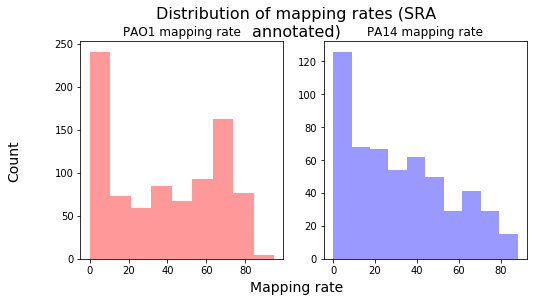

In [40]:
# Plot distribution of mapping rates to PAO1 and PA14

# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

# Distribution plot for core genes
sns.distplot(
    pao1_logs.loc[sra_pao1_sample_ids, "mapping_rate"],
    label="PAO1 (SRA annotated) mapping rate",
    color="red",
    kde=False,
    ax=axes[0],
)

sns.distplot(
    pa14_logs.loc[sra_pa14_sample_ids, "mapping_rate"],
    label="PA14 (SRA annotated) mapping rate",
    color="blue",
    kde=False,
    ax=axes[1],
)

plt.suptitle(
    fill("Distribution of mapping rates (SRA annotated)", width=40),
    x=0.5,
    y=1,
    fontsize=16,
)
axes[0].set_title(fill("PAO1 mapping rate", width=20))
axes[1].set_title(fill("PA14 mapping rate", width=20))
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.text(0.5, 0.01, "Mapping rate", ha="center", fontsize=14)
fig.text(0.01, 0.5, "Count", ha="center", rotation=90, fontsize=14)

Looks like there are fewer PA14 samples with high PA14 mapping, which explains why we see such a reduced number of PA14 binned samples. We may need to used different thresholds for PAO1 and PA14.

In [25]:
# Save compendia with label
pao1_expression_label.to_csv(paths.PAO1_COMPENDIUM_LABEL, sep="\t")
pa14_expression_label.to_csv(paths.PA14_COMPENDIUM_LABEL, sep="\t")

# Save compendia without label
pao1_expression_binned.to_csv(paths.PAO1_COMPENDIUM, sep="\t")
pa14_expression_binned.to_csv(paths.PA14_COMPENDIUM, sep="\t")

# Save metadata table
sample_to_strain_table.to_csv(paths.SAMPLE_TO_STRAIN_PROCESSED, sep="\t")